In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

## Using `tf.nn.conv2d`

This approach doesn't allow the use of grouped convolutions, so we can't 100% replicate PerceptNet with it. On the other hand, is kind of cleaner and more similar to the PyTorch approach.

In [2]:
class GDN(tf.keras.layers.Layer):
    def __init__(self,
                 n_channels,
                 gamma_init=.1,
                 reparam_offset=2**(-18),
                 beta_min=1e-6,
                 apply_independently=False,
                 data_format="channels_first"):

        super(GDN, self).__init__()
        # self.n_channels = n_channels
        self.gamma_init = gamma_init
        self.reparam_offset = reparam_offset
        self.beta_min = beta_min
        self.beta_reparam = (self.beta_min+self.reparam_offset**2)**(1/2)
        self.apply_independently = apply_independently
        self.data_format = data_format

        if apply_independently:
            self.groups = n_channels
        else:
            self.groups = 1

    def build(self, input_shape):
        """
        We could probably get rid of the n_channels variable
        by building some of the parameters here, but I'd make sure
        that we understand it and then we play around.
        """
        ## Extract the number of channels from the input shape
        ## according to the data_format
        n_channels = input_shape[-1] if self.data_format=="channels_last" else input_shape[0]

        if self.data_format=="channels_last":
            n_channels = input_shape[-1]
        elif self.data_format=="channels_first":
            n_channels = input_shape[0]
        else:
            raise ValueError("data_format not supported")

        ## First we define gamma
        gamma = tf.eye(n_channels)
        gamma = tf.reshape(gamma, shape=(*gamma.shape,1,1))
        gamma = tf.sqrt(self.gamma_init*gamma + self.reparam_offset**2)
        gamma = tf.multiply(gamma, gamma)

        if self.apply_independently:
            gamma = tf.expand_dims(gamma[:,0,:,:], axis=1)

        self.gamma = tf.Variable(initial_value=gamma,
                                 trainable=True,
                                 name="gamma",
                                 constraint=lambda x: tf.clip_by_value(x, 
                                                                       clip_value_min=self.reparam_offset,
                                                                       clip_value_max=tf.float32.max))

        ## Now we can define beta
        beta = tf.ones(shape=(n_channels,))
        beta = tf.sqrt(beta + self.reparam_offset**2)
        self.beta = tf.Variable(initial_value=beta,
                                trainable=True,
                                name="beta",
                                constraint=lambda x: tf.clip_by_value(x, 
                                                                      clip_value_min=self.beta_reparam,
                                                                      clip_value_max=tf.float32.max))

        # self.conv = tf.keras.layers.Conv2D(filters=self.gamma.shape[1],
        #                       kernel_size=self.gamma.shape[2:4],
        #                       padding="valid",
        #                       strides=1,
        #                       groups=self.groups,
        #                       data_format="channels_first",
        #                       trainable=True)

        # self.conv.build(input_shape)
        # self.gamma = self.add_weight("gamma",
        #                              shape=[input_shape])
        # pass

    def call(self, X):
        """
        The PyTorch implementation works with inputs of shape:
        [batch_size, channels, height, width].
        We'll first copy it and then we'll try to change it.
        """
        # self.gamma = tf.clip_by_value(self.gamma,
        #                               clip_value_min=self.reparam_offset,
        #                               clip_value_max=tf.float32.max)
        # self.beta = tf.clip_by_value(self.beta,
        #                              clip_value_min=self.beta_reparam,
        #                              clip_value_max=tf.float32.max)
        # print(self.gamma.dtype, self.beta.dtype)
        # self.conv.weights[0].assign(self.gamma)
        # self.conv.weights[1].assign(self.beta)
        # print(X.dtype)
        # norm_pool = self.conv(tf.multiply(X, X))
        norm_pool = tf.nn.conv2d(tf.multiply(X, X),
                                 self.gamma,
                                 strides=1,
                                 padding="VALID",
                                 data_format="NCHW")
        norm_pool += self.beta
        norm_pool = tf.sqrt(norm_pool)

        return X / norm_pool

## Custom Initializer

The in-built `Identity` initializer doesn't work with convolutions because it's only built for 2D matrices, so we're going to define our own initializer that will allow us to initialize every filter of the layer as an identity matrix:

In [46]:
class KernelIdentity(tf.keras.initializers.Initializer):

    def __init__(self, gain):
        self.gain = gain

    def __call__(self, shape, dtype=None):
        """
        shape has the form [Kx, Ky, Cin, Cout]
        """
        identity_matrix = tf.eye(shape[0])*self.gain
        identity_matrix = tf.expand_dims(identity_matrix, axis=-1)
        identity_matrix = tf.expand_dims(identity_matrix, axis=-1)
        identity_matrix = tf.repeat(identity_matrix, shape[2], axis=-2)
        identity_matrix = tf.repeat(identity_matrix, shape[3], axis=-1)
        return identity_matrix
    
    def get_config(self):
        return {'gain':self.gain}

## GDN (with Conv2D layer)

Looks like we need to use a `Conv2D` layer if we want to implement an independent GDN, because the functional `conv2d` doesn't allow the use of a `groups` parameters.

In [59]:
class GDN(tf.keras.layers.Layer):
    def __init__(self,
                 kernel_size=3,
                 gamma_init=.1,
                 alpha_init=2,
                 epsilon_init=1/2,
                 alpha_trainable=False,
                 epsilon_trainable=False,
                 reparam_offset=2**(-18),
                 beta_min=1e-6,
                 apply_independently=False,
                 data_format="channels_last"):

        super(GDN, self).__init__()
        self.kernel_size = kernel_size
        # self.n_channels = n_channels
        self.gamma_init = gamma_init
        self.reparam_offset = reparam_offset
        self.beta_min = beta_min
        self.beta_reparam = (self.beta_min+self.reparam_offset**2)**(1/2)
        self.apply_independently = apply_independently
        self.data_format = data_format
        
        ## Trainable parameters
        self.alpha = self.add_weight(shape=(1),
                                     initializer=tf.keras.initializers.Constant(alpha_init),
                                     trainable=alpha_trainable,
                                     name='alpha')
        self.epsilon = self.add_weight(shape=(1),
                                       initializer=tf.keras.initializers.Constant(epsilon_init),
                                       trainable=epsilon_trainable,
                                       name='epsilon')

    def build(self, input_shape):
        ## Extract the number of channels from the input shape
        ## according to the data_format
        n_channels = input_shape[-1] if self.data_format=="channels_last" else input_shape[0]

        if self.data_format=="channels_last":
            n_channels = input_shape[-1]
        elif self.data_format=="channels_first":
            n_channels = input_shape[0]
        else:
            raise ValueError("data_format not supported")

        if self.apply_independently:
            self.groups = n_channels
        else:
            self.groups = 1

        self.conv = layers.Conv2D(filters=n_channels,
                                  kernel_size=self.kernel_size,
                                  padding="same",
                                  strides=1,
                                  groups=self.groups,
                                  data_format=self.data_format,
                                  trainable=True,
                                  kernel_initializer=KernelIdentity(gain=self.gamma_init),
                                  kernel_constraint=lambda x: tf.clip_by_value(x, 
                                                                       clip_value_min=self.reparam_offset,
                                                                       clip_value_max=tf.float32.max),
                                  bias_initializer="ones",
                                  bias_constraint=lambda x: tf.clip_by_value(x, 
                                                                      clip_value_min=self.beta_reparam,
                                                                      clip_value_max=tf.float32.max))
        self.conv.build(input_shape)


    def call(self, X):
        """
        The PyTorch implementation works with inputs of shape:
        [batch_size, channels, height, width].
        We'll first copy it and then we'll try to change it.
        """
        norm_pool = self.conv(tf.pow(X, self.alpha))
        norm_pool = tf.pow(norm_pool, self.epsilon)

        return X / norm_pool

In [60]:
gdn = GDN(1)
gdn.build((28,28,1))

In [61]:
np.random.seed(42)
sample_input = np.random.uniform(size=(1,28,28,1))
# sample_input = tf.random.uniform(shape=(1,1,28,28))

In [62]:
a = gdn(sample_input)

In [63]:
gdn.weights

[<tf.Variable 'gdn_8/kernel:0' shape=(1, 1, 1, 1) dtype=float32, numpy=array([[[[0.1]]]], dtype=float32)>,
 <tf.Variable 'gdn_8/bias:0' shape=(1,) dtype=float32, numpy=array([1.], dtype=float32)>,
 <tf.Variable 'alpha:0' shape=(1,) dtype=float32, numpy=array([2.], dtype=float32)>,
 <tf.Variable 'epsilon:0' shape=(1,) dtype=float32, numpy=array([0.5], dtype=float32)>]

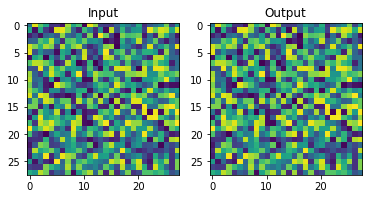

In [64]:
plt.figure()
plt.subplot(1,2,1)
plt.title("Input")
plt.imshow(sample_input.squeeze())
plt.subplot(1,2,2)
plt.imshow(a.numpy().squeeze())
plt.title("Output")
plt.show()

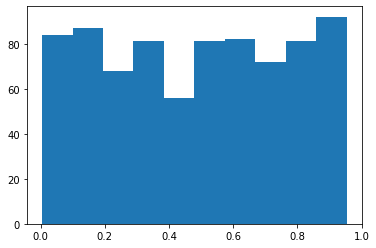

In [66]:
plt.figure()
plt.hist(a.numpy().squeeze().ravel())
plt.show()

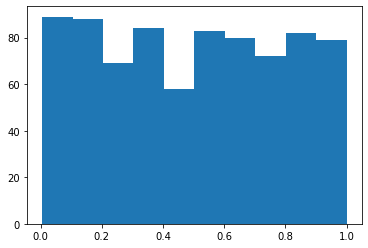

In [67]:
plt.figure()
plt.hist(sample_input.squeeze().ravel())
plt.show()

## In action!

In [22]:
from tensorflow.keras import datasets

In [23]:
(X_train, Y_train), (X_test, Y_test) = datasets.mnist.load_data()

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [24]:
X_train = tf.expand_dims(X_train, -1)
X_test = tf.expand_dims(X_test, -1)

X_train.shape, X_test.shape

(TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

In [79]:
model = tf.keras.models.Sequential([
    # tf.keras.layers.Rescaling(scale=1./255, input_shape=(1,28,28)),
    GDN(kernel_size=3, apply_independently=False,
        alpha_trainable=True, epsilon_trainable=True),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [80]:
X_train[0].shape

TensorShape([28, 28, 1])

In [81]:
a = model(tf.expand_dims(X_train[0],0)/255)

In [82]:
model.layers[0].weights[0].shape

TensorShape([1])

In [83]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gdn_10 (GDN)                 (1, 28, 28, 1)            12        
_________________________________________________________________
conv2d_15 (Conv2D)           (1, 26, 26, 32)           320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (1, 13, 13, 32)           0         
_________________________________________________________________
flatten_3 (Flatten)          (1, 5408)                 0         
_________________________________________________________________
dense_3 (Dense)              (1, 10)                   54090     
Total params: 54,422
Trainable params: 54,422
Non-trainable params: 0
_________________________________________________________________


In [84]:
history = model.fit(X_train/255, Y_train, 
                    epochs=5,
                    validation_data=(X_test/255, Y_test))

Epoch 1/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2017 - accuracy: 0.9412 - val_loss: 0.0833 - val_accuracy: 0.9736
Epoch 2/5
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0701 - accuracy: 0.9792 - val_loss: 0.0644 - val_accuracy: 0.9791
Epoch 3/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0531 - accuracy: 0.9846 - val_loss: 0.0604 - val_accuracy: 0.9809
Epoch 4/5
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0429 - accuracy: 0.9867 - val_loss: 0.0586 - val_accuracy: 0.9816
Epoch 5/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0341 - accuracy: 0.9894 - val_loss: 0.0600 - val_accuracy: 0.9814


In [85]:
model.layers[0].weights

[<tf.Variable 'alpha:0' shape=(1,) dtype=float32, numpy=array([2.8048022], dtype=float32)>,
 <tf.Variable 'epsilon:0' shape=(1,) dtype=float32, numpy=array([1.0773705], dtype=float32)>,
 <tf.Variable 'gdn_10/kernel:0' shape=(3, 3, 1, 1) dtype=float32, numpy=
 array([[[[0.01211443]],
 
         [[0.00056146]],
 
         [[0.0001425 ]]],
 
 
        [[[0.02278794]],
 
         [[0.00185108]],
 
         [[0.00999017]]],
 
 
        [[[0.01037717]],
 
         [[0.00461366]],
 
         [[0.00836389]]]], dtype=float32)>,
 <tf.Variable 'gdn_10/bias:0' shape=(1,) dtype=float32, numpy=array([0.34379348], dtype=float32)>]

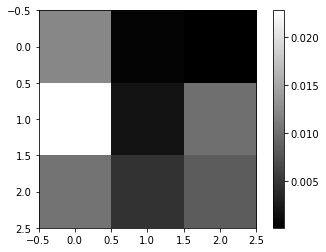

In [88]:
plt.figure()
plt.imshow(model.layers[0].weights[2].numpy().squeeze(), cmap='gray')
plt.colorbar()
plt.show()

In [89]:
gdn_activation = model.layers[0](tf.expand_dims(X_train[0],0)/255)
gdn_activation.shape

TensorShape([1, 28, 28, 1])

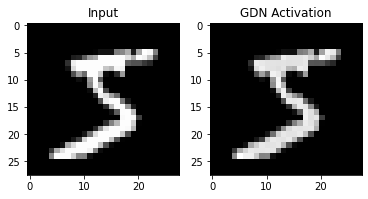

In [91]:
plt.figure()
plt.subplot(1,2,1)
plt.title("Input")
plt.imshow(X_train[0], cmap='gray')
plt.subplot(1,2,2)
plt.title("GDN Activation")
plt.imshow(gdn_activation.numpy().squeeze(), cmap='gray')
plt.show()